In [1]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML # rendering animations
from tqdm import tqdm
import xarray as xr 
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

In [2]:
small_action_dict = {
    0: {"name":"Up", "label":"↑", "delta":(0,1)},
    1: {"name":"Right", "label":"→", "delta":(1,0)},
    2: {"name":"Down", "label":"↓", "delta":(0,-1)},
    3: {"name":"Left", "label":"←", "delta":(-1,0)},}

In [4]:
def epsilon_greedy_policy(Q_values, epsilon=0.1):
    """
    Q_values are the Q values for each possible action in the current state, shape = (n_actions,)
    epsilon is the probability of selecting a random action
    """
    n_actions = Q_values.shape[0]
    
    if np.random.rand() < epsilon:
        return np.random.randint(0, n_actions)
    else:
        return np.argmax(Q_values)

In [5]:
class BaseTDLearner:
    """
    Base class for the Temporal Difference (TD) learning algorithm.
    """
    def __init__(self,gamma=0.5, alpha=0.1, n_states=10,):
        """
        Initialize the TD learning algorithm.
        
        Parameters:
        - gamma: The discount factor.
        - alpha: The learning rate.
        - n_states: The number of states.
        """
        self.V = np.zeros(n_states)
        self.S_prev = None
        self.gamma = gamma
        self.alpha = alpha
        self.n_states = n_states

        #History data (for plotting) 
        self.V_history = []
        self.S_history = []
        self.R_history = []
        self.TD_history = []
        # in it's learning Q values 
        self.Q_history = []
        self.A_history = []

        self.theoretical_value = None # if not None, this is will be plotted on top 

    def learn_episode(self, 
                    states : np.ndarray, 
                    rewards : np.ndarray,):
            """
            Learn from an episode of states and rewards.
            
            Parameters:
            - states: The states visited in the episode, represented as a numpy array of integers.
            - rewards: The rewards received after each state in the episode, represented as a numpy array of floats.
            """
            states = np.array(states)
            rewards = np.array(rewards)
            assert len(states) == len(rewards), "States and rewards must be the same length"

            T_episode = len(states)+ 1 # get the length of the episode (including the initial None state)

            # Insert an unrewarded "None" state at the beginning to indicate the start of an episode
            rewards = np.insert(rewards, 0, 0)
            states = np.insert(states.astype(object), [0, len(states)], [None, None])

            # Loop over the states and learn from each transition
            TD_errors = np.empty(T_episode) # store the TD errors
            for i in range(T_episode):
                # Learn from this transition
                TD_errors[i] = self.learn(states[i], states[i+1], rewards[i])
            
            # Save to history 
            self.V_history.append(self.V.copy())
            self.S_history.append(states[:T_episode])
            self.TD_history.append(TD_errors)
            self.R_history.append(rewards)
    

In [6]:
class BaseTDQLearner(BaseTDLearner):
    """
    Base class for Temporal Difference Q-Learning algorithms.

    Args:
        gamma (float): Discount factor for future rewards. Default is 0.5.
        alpha (float): Learning rate. Default is 0.1.
        n_states (int): Number of states in the environment. Default is 10.
        n_actions (int): Number of actions in the environment. Default is 4.
    """

    def __init__(self, gamma=0.5, alpha=0.1, n_states=10, n_actions=4):
        super(BaseTDQLearner, self).__init__(gamma=gamma, alpha=alpha, n_states=n_states)

    def learn_episode(
        self,
        states : np.ndarray, 
        actions : np.ndarray,
        rewards : np.ndarray,
    ):
        """
        Learn from a single episode of transitions.

        Args:
            states (np.ndarray): Array of states visited during the episode.
            actions (np.ndarray): Array of actions taken during the episode.
            rewards (np.ndarray): Array of rewards received during the episode.
        """

        T_episode = len(states) + 1 # get the length of the episode (including the initial None state)

        # Insert an unrewarded "None" state at the beginning to indicate the start of an episode
        rewards = np.insert(rewards, 0, 0)
        states = np.insert(states.astype(object), [0, len(states)], [None, None])
        actions = np.insert(actions.astype(object), [0, len(actions)], [None, None])

        # Loop over the states and learn from each transition
        TD_errors = np.empty(T_episode) # store the TD errors
        for i in range(T_episode):
            # Learn from this transition
            TD_errors[i] = self.learn(states[i], states[i+1], actions[i], actions[i+1], rewards[i])
        
        # Save to history 
        self.Q_history.append(self.Q.copy())
        self.S_history.append(states[:T_episode])
        self.A_history.append(states[:T_episode])
        self.TD_history.append(TD_errors)
        self.R_history.append(rewards)
        self.V_history.append(np.mean(self.Q, axis=1))

In [7]:
class TDQLearner(BaseTDQLearner):
    def __init__(self, gamma=0.5, alpha=0.1, n_states=10, n_actions=2):
        self.Q = np.zeros((n_states, n_actions))
        self.n_actions = n_actions
        super().__init__(gamma=gamma, alpha=alpha, n_states=n_states)

    def learn(self, S, S_next, A, A_next, R):
        # Get's the value of the current and next state
        Q = 0 if S is None else self.Q[S, A] # get the value of the current state (remember it's zero if S is None)
        Q_next = 0 if S_next is None else self.Q[S_next, A_next] # get the value of the next state

        # Calculates the TD error (hint remember to use self.gamma
        TD_error = R + self.gamma * Q_next - Q # calculate the TD error

        # Updates the value of the current state
        if S is not None:
            self.Q[S,A] = Q + TD_error # update the Q value

        return TD_error

In [8]:
class MiniGrid():
    """
    Represents a grid environment for reinforcement learning.

    Parameters:
    - grid : np.ndarray, optional
        The grid representation of the environment.
    - reward_locations : list, optional
        The locations of the rewards in the grid. Default is [(5,5)].
    - reward_values : list, optional
        The values of the rewards. Default is [10].
    - max_steps : int, optional
        The maximum number of steps allowed in an episode. Default is 100.
    - action_dict : dict, optional
        A dictionary mapping action indices to action labels. Default is small_action_dict.
    - cost_per_step : float, optional
        The cost incurred per step. Default is 0.1.
    - cost_per_wall_collision : float, optional
        The cost incurred per wall collision. Default is 1.
    """

    def __init__(
        self,
        grid : np.ndarray = None,
        pk_hw = 2,
        reward_locations : list = [(5,5)],
        reward_values : list = [10],
        max_steps = 100,
        action_dict = small_action_dict, 
        cost_per_step = 0.1,
        cost_per_wall_collision = 1,
    ):
        """
        Initializes the MiniGrid environment.

        Parameters:
        - grid : np.ndarray, optional
            The grid representation of the environment. 
        - reward_locations : list, optional
            The locations of the rewards in the grid. Default is [(5,5)].
        - reward_values : list, optional
            The values of the rewards. Default is [10].
        - max_steps : int, optional
            The maximum number of steps allowed in an episode. Default is 100.
        - action_dict : dict, optional
            A dictionary mapping action indices to action labels. Default is small_action_dict.
        - cost_per_step : float, optional
            The cost incurred per step. Default is 0.1.
        - cost_per_wall_collision : float, optional
            The cost incurred per wall collision. Default is 1.
        """
        
        if grid is not None:
            self.grid = grid
            self.width = grid.shape[1]
            self.height = grid.shape[0]
            self.x_coords = np.arange(self.width)
            self.y_coords = np.arange(self.height)[::-1]
            self.grid_shape = (self.height, self.width)
            self.n_states = self.width * self.height
            self.pk_hw = pk_hw
        
        self.reward_locations = reward_locations
        self.reward_values = reward_values
        assert len(reward_locations) == len(reward_values), "Reward locations and values must be the same length"

        self.cost_per_step = cost_per_step
        self.cost_per_wall_collision = cost_per_wall_collision
        self.max_steps = max_steps
        self.reward_extent = 1 #effective size of reward is 1 (1 grid)
        self.agent_extent = 1 #effective size of agent is 1 (1 grid)
        self.episode_number = 0 
        self.recent_episode_length = self.max_steps
        self.episode_history = {}
        self.av_time_per_episode = self.max_steps
        self.episode_lengths = []

        self.action_dict = action_dict
        self.n_actions = len(self.action_dict)

        self.reset()

    def step(self, action):
        """
        Takes a step in the environment based on the given action.

        Parameters:
        - action : int
            The index of the action to take.
        """
        if action == 0:
            step_arr = np.array((0, 1)) # Up
        elif action == 1:
            step_arr = np.array((1, 0)) # Right
        elif action == 2:
            step_arr = np.array((0, -1)) # Down
        elif action == 3:
            step_arr = np.array((-1, 0)) # Left

        # Propose a new position based on the action
        proposed_new_pos = tuple(np.array(self.agent_pos) + step_arr)

        # Check if the new position is a wall or reward
        is_wall = self.is_wall(proposed_new_pos) # returns True if the proposed new position is a wall
        if not is_wall:
            self.agent_pos = proposed_new_pos
            self.agent_direction = action

        # Check if the new position is a reward
        reward = self.get_reward(proposed_new_pos) # returns any reward found at the proposed new position
        is_terminal = (reward > 0) # If a reward is found then the episode is over
        reward -= self.cost_per_step # consider adding other contributions to the reward from moving costs or hitting walls
        if is_wall:
            reward -= self.cost_per_wall_collision

        # Get the new state
        state = self.pos_to_state(self.agent_pos)

        return state, reward, is_terminal
    
    def train(self, tdqlearner, n_episodes=1000, max_episode_length=100, policy=epsilon_greedy_policy,):

        for i in (pbar := tqdm(range(n_episodes))):

            try: # this just allows you to stop the loop by pressing the stop button in the notebook

                # Initialise an episode:
                terminal = False
                self.reset() # reset the environment
                state = self.pos_to_state(self.agent_pos)
                action = policy(tdqlearner.Q[state])

                episode_data = {'positions': [], 'states':[], 'actions':[], 'rewards':[]}
    
                step = 0
                while not terminal and step < max_episode_length:
                    # Get the next state and reward using the step() method
                    state_next, reward, terminal = self.step(action)
                    
                    if terminal:
                        state_next = None
                        next_action = None
                    else:
                        # Get the next action using the policy() function
                        next_action = policy(tdqlearner.Q[state_next])

                    # Learn from the transition using the tdqlearner.learn() method
                    tdqlearner.learn(S = state, S_next = state_next, A = action, A_next = next_action, R=reward)

                    # store the data
                    episode_data['positions'].append(self.agent_pos)
                    episode_data['states'].append(state)
                    episode_data['actions'].append(action)
                    episode_data['rewards'].append(reward)

                    # update the state and action
                    state = state_next
                    action = next_action 
                    step += 1

                self.episode_history[self.episode_number] = episode_data
                self.episode_number += 1
                self.episode_lengths.append(step)

            except KeyboardInterrupt:
                break

    def reset(self):
        """
        Resets the environment by placing the agent at a random position and direction.
        """
        self.agent_pos = (self.width // 2, self.height // 2)
        self.agent_direction = np.random.randint(self.n_actions)
        
    def is_wall(self, pos : tuple): 
        """
        Checks if the given position is a wall.

        Parameters:
        - pos : tuple
            The position to check.

        Returns:
        - bool: True if the position is a wall, False otherwise.
        """
        (x, y) = pos
        val_at_pos = self.grid[self.height - 1 - y, x] # y is flipped because of the way the grid is plotted
        val_at_pos = 1 if val_at_pos == 0 else 0
        return val_at_pos
        # return self.grid[self.height - 1 - y, x] # y is flipped because of the way the grid is plotted
        
    def get_reward(self, pos : tuple):
        """
        Gets the reward value at the given position.

        Parameters:
        - pos : tuple
            The position to get the reward value for.

        Returns:
        - float: The reward value at the given position.
        """
        if pos in self.reward_locations:
            return self.reward_values[self.reward_locations.index(pos)]
        else:
            return 0
    
    def plot_episode(self, episode_number=None, ax=None, stop_at_step=None):
        """
        Plots the trajectory of an episode.

        Parameters:
        - episode_number : int, optional
            The episode number to plot. If not provided, the most recent episode will be plotted.
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.
        - stop_at_step : int, optional
            The step at which to stop plotting. If not provided, the entire episode will be plotted.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if episode_number is None:
            episode_number = self.episode_number - 1
        else: 
            episode_number = np.arange(self.episode_number)[episode_number]
        episode_data = self.episode_history[episode_number]
        positions = episode_data["positions"]
        actions = episode_data["actions"]
        if ax is None:
            ax = self._plot_env(ax=ax)
            ax = self._plot_rewards(ax)
        if stop_at_step is None: stop_at_step = len(positions)
        for i in range(stop_at_step):
            episode_frac = i/len(positions)
            ax = self._plot_agent(agent_pos=positions[i], agent_direction=actions[i], ax=ax, color = plt.cm.viridis(1-episode_frac), size_scaler=(1+episode_frac)/2, alpha = (1+episode_frac)/2)
            if i > 0:
                ax.plot([positions[i-1][0], positions[i][0]], [positions[i-1][1], positions[i][1]], color=plt.cm.viridis(1-episode_frac), alpha = (1+episode_frac)/2, linewidth=0.5)
        
        return ax

    def plot_Q(self, Q_values):
        """
        Plots the Q-values of the environment.

        Parameters:
        - Q_values : np.ndarray
            The Q-values of the environment.

        Returns:
        - list: The list of axes objects containing the plots.
        """
        assert (Q_values.shape == (self.n_states, self.n_actions)), f"Q_values must be of shape (n_states, n_actions) = ({self.n_states}, {self.n_actions}) but got {Q_values.shape}"
        
        # Q_values is shape (n_states, n_actions) so we need to reshape it to (height, width, n_actions). However by default numpy.reshape reads the array in row-major order, so we need to transpose the first two dimensions

        Q_values_grid = Q_values.reshape(self.grid_shape[0], self.grid_shape[1], self.n_actions)

        min_Q = np.min(Q_values)
        max_Q = np.max(Q_values)

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(3, 3, hspace=0.15, wspace=0.15)
        axN = fig.add_subplot(gs[0, 1])
        axW = fig.add_subplot(gs[1, 0])
        axE = fig.add_subplot(gs[1, 2])
        axS = fig.add_subplot(gs[2, 1])
        axC = fig.add_subplot(gs[1, 1])
        axs = [axN, axE, axS, axW, axC]
        for i in range(self.n_actions):
            axs[i] = self._plot_env(ax=axs[i])
            axs[i] = self._plot_rewards(ax=axs[i])
            axs[i].imshow(Q_values_grid[:,:,i], cmap="viridis", extent=[-0.5, self.width-0.5, -0.5, self.height-0.5], alpha=0.5, vmax=max_Q, vmin=min_Q)
            axs[i].set_title(f"Q(s,{self.action_dict[i]['label']})", color=plt.colormaps['twilight'](i / self.n_actions))
            if i > 0:
                axs[i].set_yticks([])
                axs[i].set_ylabel("")
        axC = self._plot_env(ax=axC)
        axC = self._plot_rewards(ax=axC)
        axC = self.plot_policy(Q_values, ax=axC)
        axC.set_title("π(s)")
        return axs
    
    def plot_training(self, ax=None):
        """
        Plots the training progress.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 2))
        episode_lengths = np.array([len(self.episode_history[i]["states"]) for i in range(self.episode_number)])
        n_eps = len(episode_lengths)
        smoothed_episode_lengths = [np.mean(episode_lengths[max(0, i-100):i+1]) for i in range(n_eps)]
        ax.scatter(np.arange(self.episode_number), episode_lengths, linewidth=0, alpha=0.5,c='C0', label="Episode length")
        ax.plot(np.arange(len(smoothed_episode_lengths)), smoothed_episode_lengths, color='k',linestyle="--",linewidth=0.5, label = "Smoothed")
        ax.set_xlabel("Episode")
        ax.legend()

        return ax
    
    def render(self, ax=None):
        """
        Renders the current state of the environment.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        ax = self._plot_env(ax=ax)
        ax = self._plot_agent(ax=ax,agent_pos=self.agent_pos, agent_direction=self.agent_direction)
        ax = self._plot_rewards(ax)
        return ax 

    def plot_first_and_last_5_episodes(self):
        """
        Plots the trajectories of the first and last 5 episodes.

        Returns:
        - numpy.ndarray: The array of axes objects containing the plots.
        """
        fig, ax = plt.subplots(2,5, figsize=(10,4))
        for i in range(5):

            ax[0,i] = self._plot_env(ax=ax[0,i])
            ax[1,i] = self._plot_env(ax=ax[1,i])
            ax[0,i] = self._plot_rewards(ax=ax[0,i])
            ax[1,i] = self._plot_rewards(ax=ax[1,i])
        
            self.plot_episode(i, ax=ax[0,i])
            self.plot_episode(-i-1, ax=ax[1,i])
            if i == 2: 
                ax[0,i].set_title("First 5 episodes")
                ax[1,i].set_title("Last 5 episodes")
        return ax
    
    def _plot_env(self, ax=None):
        """
        Plots the environment grid.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.2*self.width, 0.2*self.height))

        pk_qw = self.pk_hw // 2
        thinned_grid = self.grid[pk_qw:-pk_qw, pk_qw:-pk_qw]
        inverted_grid = 1 - thinned_grid
        im = ax.imshow(inverted_grid, cmap="Greys", zorder=20, alpha=inverted_grid.astype(float), extent=[-0.5, self.width-0.5, -0.5, self.height-0.5])

        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        return ax 

    def _plot_rewards(self, ax, **kwargs):
        """
        Plots the rewards in the environment.

        Parameters:
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        for (i,reward) in enumerate(self.reward_locations):
            reward_value = self.reward_values[i]
            max_rv, min_rv = np.max(self.reward_values), np.min(self.reward_values)
            # color = plt.colormaps['plasma']((reward_value - min_rv) / max(1, max_rv - min_rv))
            reward_patch = plt.Circle(reward, self.reward_extent * (0.4 + 0.3*((reward_value - min_rv) / max(1, max_rv - min_rv))), color='orange',zorder=2)
            ax.add_patch(reward_patch)
            ax.text(reward[0], reward[1], "R", color='white', weight="bold",fontsize=4, ha='center', va='center',alpha=0.5)
        return ax
    
    def _plot_arrow(self, pos, direction, ax, **kwargs):
        """
        Plots an arrow indicating the agent's direction.

        Parameters:
        - pos : tuple
            The position of the arrow.
        - direction : int
            The direction of the arrow.
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = kwargs.get("size_scaler", 1)
        # Define the base triangle vertices relative to origin
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]]) - np.array([0.5,0.5])
        scaled_triangle = base_triangle * size_scaler
        # Define the rotation matrix based on direction
        angle = (2*np.pi - (direction/self.n_actions)*2*np.pi) # assumes action evenly spaced around circle
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                    [np.sin(angle), np.cos(angle)]])
        # Rotate the triangle
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)   
        # Translate the triangle to the agent position
        translated_triangle = rotated_triangle + np.array(pos)
        # Plot the triangle
        triangle = plt.Polygon(translated_triangle, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax

    def _plot_circle(self, pos, ax, **kwargs):
        """
        Plots a circle representing a position in the environment.

        Parameters:
        - pos : tuple
            The position of the circle.
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = 0.5*kwargs.get("size_scaler", 1)
        circle = plt.Circle(pos, size_scaler, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(circle)
        return ax
    
    def _plot_agent(self, ax, agent_pos, agent_direction,  **kwargs):
        """
        Plots the agent in the environment.

        Parameters:
        - ax : matplotlib.axes.Axes
            The axes to plot on.
        - agent_pos : tuple
            The position of the agent.
        - agent_direction : int
            The direction of the agent.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        size_scaler = kwargs.pop("size_scaler", 1)
        size_scaler *= self.agent_extent
        ax = self._plot_circle(pos=agent_pos, direction=agent_direction, ax=ax, size_scaler=size_scaler, **kwargs)
        return ax

    def animate_episodes(self,episodes=None, **kwargs):
        if episodes is None:
            episode = [self.episode_number - 1]
        def update(frames, ax):
            episode, frame = frames
            ax.clear()
            ax = self._plot_env(ax=ax)
            ax = self._plot_rewards(ax)
            ax = self.plot_policy(**kwargs, ax=ax)
            ax = self.plot_episode(episode_number=episode, ax=ax, stop_at_step=frame)
            plt.close()
            return ax
        
        axs = self.plot_Q(**kwargs)
        ep_fr = [(episode, frame) for episode in episodes for frame in range(len(self.
        episode_history[episode]["positions"]))]

        anim = FuncAnimation(plt.gcf(), update, frames=ep_fr, fargs=(axs[-1],), interval=100)        
        plt.close()
        return anim

    def plot_policy(self, Q_values, ax=None): 
        Q_values = Q_values.reshape(self.grid_shape[0], self.grid_shape[1], self.n_actions)
        optimal_actions = Q_values.argmax(axis=2)
        if ax is None:
            ax = self._plot_env()
            ax = self._plot_rewards(ax)
        for x in self.x_coords:
            for y in self.y_coords:
                if self.is_wall((x,y)):
                    continue
                action = optimal_actions[self.height-1-y,x]
                color = plt.colormaps['twilight'](action / self.n_actions)
                ax = self._plot_arrow(pos=(x,y), direction=action, ax=ax, color = color, size_scaler=0.5*self.agent_extent)
        
        return ax

    def pos_to_state(self, pos):
        return (self.height - 1 - pos[1]) * self.width + pos[0]  

In [9]:
width=11
height=5
pk = 4
pk_hw = 2

env = np.zeros((height, width, 3))
env[:, :, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))

In [10]:
grid = env[:, :, -1]

minigrid_env = MiniGrid(
    grid = grid,
    pk_hw=pk_hw,
    reward_locations = [((width + pk)//2, pk_hw)],
    reward_values = [10],
    cost_per_step=1,
    cost_per_wall_collision=1,
    )

100%|██████████| 1000/1000 [00:00<00:00, 36038.49it/s]


array([[<Axes: >, <Axes: >, <Axes: title={'center': 'First 5 episodes'}>,
        <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: title={'center': 'Last 5 episodes'}>,
        <Axes: >, <Axes: >]], dtype=object)

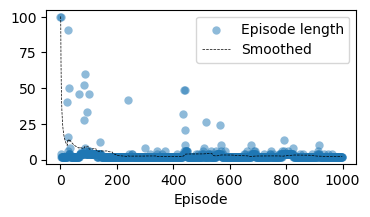

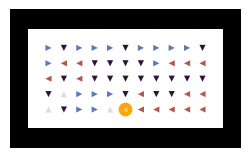

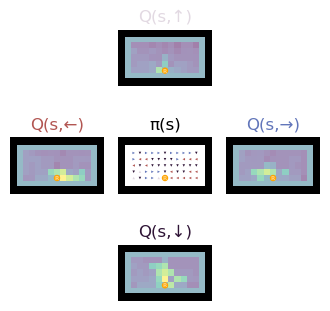

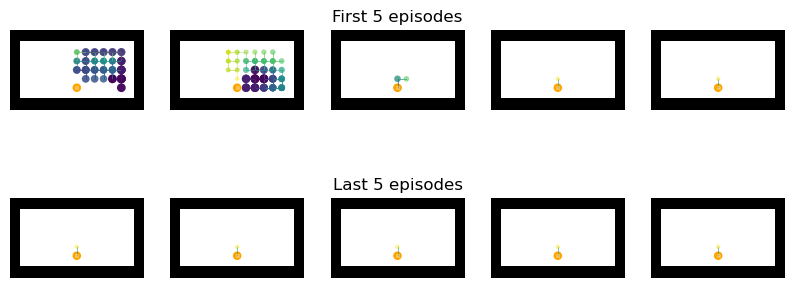

In [11]:
tdqlearner_env = TDQLearner(
    gamma=0.9,
    alpha=0.05,
    n_states=minigrid_env.n_states,
    n_actions=minigrid_env.n_actions)

minigrid_env.train(
    tdqlearner_env,
    n_episodes=1000,
    policy=lambda Q: epsilon_greedy_policy(Q, epsilon=0.05),)

minigrid_env.plot_training()

# Plot Q values along central row and see where west and east cross
minigrid_env.plot_policy(tdqlearner_env.Q)
minigrid_env.plot_Q(tdqlearner_env.Q)
minigrid_env.plot_first_and_last_5_episodes()